### 참고 사이트

Data Augmetation 코드 - https://github.com/franneck94/Cifar-10-Data-Augmentation/blob/master/cifar10.py<br>
Augmetation 인자 설명 - https://tykimos.github.io/2017/06/10/CNN_Data_Augmentation/ <br>
cf) ResNet 관련 설명 - https://dnddnjs.github.io/cifar10/2018/10/07/start_cifar10/#fn:4
* rotation_range - 지정된 각도 범위 내에서 임의로 원본 이미지를 회전시킨다. 0~90사이
* width_shift_range - 지정된 수평방향 이동 범위 내에서 임의로 원본 이미지를 이동시킨다. 수치는 전체 지율로 나타난다. 전체 픽셀에서 주어진 퍼센트 만큼 이동한다
* height_shift_range - 위아래로 이동
* shear_range - 주어진 라디안 범위 내에서 시계 반대 방향으로 돌림
* zoom_range - 지정된 확대/축소 범위 내에서 임의로 원본 이미지를 확대,축소 / 0.3으로 주면 0.7~1.3으로 변화시킴
* horizontal_flit = True / 위아래 뒤집기, vertical_flip은 좌우대칭

In [1]:
# Config
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split

import tensorflow as tf
import numpy as np
import os
import sys
from six.moves import cPickle
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def load_data():
    # Modify path string. use your path which your dataset is in
    path =  r'C:\Users\strea\Links\baseline_code_final (2)'
    fpath = os.path.join(path, 'train_data')
    
    with open(fpath, 'rb') as f:
        d = cPickle.load(f, encoding='bytes')
    X_train = d['data']
    y_train = d['labels']
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32) # 3072개 숫자가 한줄로 이어진 배열 하나를 32x32짜리 배열 3개로 만듦
    X_train = X_train.transpose(0, 2, 3, 1)
    y_train = np.reshape(y_train, (len(y_train), 1))
    return X_train, y_train

In [3]:
class CIFAR10:
    x_train, y_train= None, None
    train_size = 0

    def __init__(self):   
        self.x_train, self.y_train = load_data()
        self.train_size = self.x_train.shape[0]
   
    def data_augmentation(self, augment_size=20000, rotate=10, zoom=0.05, width=0.07, height=0.07, vertical=False, shear=0.01): 
        image_generator = ImageDataGenerator(
            rotation_range = rotate,
            zoom_range = zoom, 
            width_shift_range = width,
            height_shift_range = height,
            horizontal_flip =False,
            vertical_flip = vertical,
            shear_range = shear,
            data_format="channels_last",
            zca_whitening=True)
        # fit data for zca whitening
        image_generator.fit(self.x_train, augment=True)
        # get transformed images
        randidx = np.random.randint(self.train_size, size=augment_size)
        x_augmented = self.x_train[randidx].copy()
        y_augmented = self.y_train[randidx].copy()
        x_augmented = image_generator.flow(x_augmented, np.zeros(augment_size),
                                    batch_size=augment_size, shuffle=False).next()[0]
        # append augmented data to trainset
        self.x_train = np.concatenate((self.x_train, x_augmented))
        self.y_train = np.concatenate((self.y_train, y_augmented))
        self.train_size = self.x_train.shape[0]

C:\ProgramData\Anaconda3\envs\p36\lib\site-packages\keras_preprocessing\image\image_data_generator.py:334: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


x_train shape: (60000, 32, 32, 3)
60000 train samples


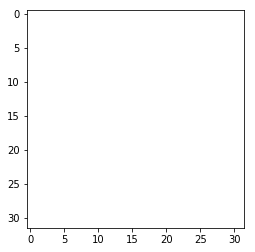

In [4]:
# 1시간 정도 걸림
cifa = CIFAR10()
# 2만개씩 생성 - 10번, 20만개
cifa.data_augmentation(vertical=True)
# cifa.data_augmentation(rotate=30, zoom=0.15)
# cifa.data_augmentation(rotate=35, zoom=0.1, vertical=True)
# cifa.data_augmentation(rotate=45, width=0.15)
# cifa.data_augmentation(rotate=50, width=0.1, vertical=True)
# cifa.data_augmentation(rotate=35, height=0.15)
# cifa.data_augmentation(rotate=40, height=0.1, vertical=True)
# cifa.data_augmentation(rotate=15, shear=0.5)
# cifa.data_augmentation(rotate=20, shear=0.25, vertical=True)
# cifa.data_augmentation(rotate=30, , zoom=0.2, height=0.15, weight=0.2 vertical=True)
x_train, y_train = cifa.x_train, cifa.y_train
# Check your data
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
plt.imshow(x_train[0])
plt.show()

In [5]:
batch_size = 256
num_classes = 10
epochs = 1000

# Steps_per_epoch should typically be equal to the number of unique samples of your dataset divided by the batch size.
steps_per_epoch = int(x_train.shape[0]/batch_size)
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = '60102358_trained_model.h5'

In [6]:
y_train = keras.utils.to_categorical(y_train, num_classes)
x_train = x_train.astype('float32')
x_train /= 255
x_train.shape, y_train.shape

((60000, 32, 32, 3), (60000, 10))

In [7]:
# seed 값 설정
seed = 0
np.random.seed(seed)
tf.set_random_seed(seed)

X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=seed)

In [12]:
# 모델 저장 폴더 설정
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    
# 모델 저장 조건 설정
modelpath = MODEL_DIR + '{epoch:02d}-{loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='loss', verbose=1, save_best_only=True)
# loss는 train loss고 val_loss는 validation loss임 / acc도 마찬가지

In [13]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

datagen = ImageDataGenerator()
datagen.fit(X_train)

In [14]:
# Train
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    workers=4, 
                    callbacks=[checkpointer])
# , validation_split=0.3
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Epoch 1/1000
234/234 [==============================] - 4s 15ms/step - loss: 2.0605 - acc: 0.2396

Epoch 00001: loss improved from inf to 2.06183, saving model to ./model/01-2.0618.hdf5
Epoch 2/1000
234/234 [==============================] - 3s 14ms/step - loss: 1.9685 - acc: 0.2818

Epoch 00002: loss improved from 2.06183 to 1.96763, saving model to ./model/02-1.9676.hdf5
Epoch 3/1000
234/234 [==============================] - 3s 14ms/step - loss: 1.9378 - acc: 0.3003

Epoch 00003: loss improved from 1.96763 to 1.93839, saving model to ./model/03-1.9384.hdf5
Epoch 4/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.9158 - acc: 0.3078

Epoch 00004: loss improved from 1.93839 to 1.91526, saving model to ./model/04-1.9153.hdf5
Epoch 5/1000
234/234 [==============================] - 3s 14ms/step - loss: 1.9037 - acc: 0.3147

Epoch 00005: loss improved from 1.91526 to 1.90457, saving model to ./model/05-1.9046.hdf5
Epoch 6/1000
234/234 [==============================] 

234/234 [==============================] - 3s 13ms/step - loss: 1.7847 - acc: 0.3636

Epoch 00047: loss improved from 1.78704 to 1.78439, saving model to ./model/47-1.7844.hdf5
Epoch 48/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.7906 - acc: 0.3625

Epoch 00048: loss did not improve from 1.78439
Epoch 49/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.7842 - acc: 0.3627

Epoch 00049: loss did not improve from 1.78439
Epoch 50/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.7814 - acc: 0.3643

Epoch 00050: loss improved from 1.78439 to 1.78174, saving model to ./model/50-1.7817.hdf5
Epoch 51/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.7821 - acc: 0.3656

Epoch 00051: loss did not improve from 1.78174
Epoch 52/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.7775 - acc: 0.3665

Epoch 00052: loss improved from 1.78174 to 1.77919, saving model to ./model/52-1.7792.hdf5


234/234 [==============================] - 3s 13ms/step - loss: 1.7438 - acc: 0.3790

Epoch 00096: loss improved from 1.74386 to 1.74228, saving model to ./model/96-1.7423.hdf5
Epoch 97/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.7397 - acc: 0.3798

Epoch 00097: loss improved from 1.74228 to 1.74170, saving model to ./model/97-1.7417.hdf5
Epoch 98/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.7434 - acc: 0.3803

Epoch 00098: loss did not improve from 1.74170
Epoch 99/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.7374 - acc: 0.3802

Epoch 00099: loss improved from 1.74170 to 1.73833, saving model to ./model/99-1.7383.hdf5
Epoch 100/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.7407 - acc: 0.3780

Epoch 00100: loss did not improve from 1.73833
Epoch 101/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.7343 - acc: 0.3808

Epoch 00101: loss improved from 1.73833 to 1.

234/234 [==============================] - 3s 13ms/step - loss: 1.7185 - acc: 0.3910

Epoch 00145: loss did not improve from 1.71067
Epoch 146/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.7151 - acc: 0.3881

Epoch 00146: loss did not improve from 1.71067
Epoch 147/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.7124 - acc: 0.3927

Epoch 00147: loss did not improve from 1.71067
Epoch 148/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.7088 - acc: 0.3913

Epoch 00148: loss improved from 1.71067 to 1.71045, saving model to ./model/148-1.7104.hdf5
Epoch 149/1000
234/234 [==============================] - 3s 14ms/step - loss: 1.7165 - acc: 0.3899

Epoch 00149: loss did not improve from 1.71045
Epoch 150/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.7119 - acc: 0.3900

Epoch 00150: loss did not improve from 1.71045
Epoch 151/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.7

234/234 [==============================] - 3s 13ms/step - loss: 1.6892 - acc: 0.4011

Epoch 00197: loss improved from 1.69048 to 1.68789, saving model to ./model/197-1.6879.hdf5
Epoch 198/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.6911 - acc: 0.3997

Epoch 00198: loss did not improve from 1.68789
Epoch 199/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.6931 - acc: 0.3965

Epoch 00199: loss did not improve from 1.68789
Epoch 200/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.6905 - acc: 0.3977

Epoch 00200: loss did not improve from 1.68789
Epoch 201/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.6918 - acc: 0.3999

Epoch 00201: loss did not improve from 1.68789
Epoch 202/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.6869 - acc: 0.4006

Epoch 00202: loss improved from 1.68789 to 1.68675, saving model to ./model/202-1.6867.hdf5
Epoch 203/1000
234/234 [=============

234/234 [==============================] - 3s 13ms/step - loss: 1.6736 - acc: 0.4055

Epoch 00248: loss did not improve from 1.67252
Epoch 249/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.6704 - acc: 0.4063

Epoch 00249: loss improved from 1.67252 to 1.67249, saving model to ./model/249-1.6725.hdf5
Epoch 250/1000
234/234 [==============================] - 3s 15ms/step - loss: 1.6700 - acc: 0.4056

Epoch 00250: loss improved from 1.67249 to 1.66932, saving model to ./model/250-1.6693.hdf5
Epoch 251/1000
234/234 [==============================] - 4s 15ms/step - loss: 1.6742 - acc: 0.4059

Epoch 00251: loss did not improve from 1.66932
Epoch 252/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.6733 - acc: 0.4073

Epoch 00252: loss did not improve from 1.66932
Epoch 253/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.6678 - acc: 0.4076

Epoch 00253: loss improved from 1.66932 to 1.66831, saving model to ./model/253-1.66

234/234 [==============================] - 3s 14ms/step - loss: 1.6590 - acc: 0.4095

Epoch 00299: loss did not improve from 1.65769
Epoch 300/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.6545 - acc: 0.4130

Epoch 00300: loss improved from 1.65769 to 1.65550, saving model to ./model/300-1.6555.hdf5
Epoch 301/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.6593 - acc: 0.4104

Epoch 00301: loss did not improve from 1.65550
Epoch 302/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.6584 - acc: 0.4137

Epoch 00302: loss did not improve from 1.65550
Epoch 303/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.6560 - acc: 0.4124

Epoch 00303: loss did not improve from 1.65550
Epoch 304/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.6598 - acc: 0.4082

Epoch 00304: loss did not improve from 1.65550
Epoch 305/1000
234/234 [==============================] - 3s 14ms/step - loss: 1.6

234/234 [==============================] - 3s 13ms/step - loss: 1.6415 - acc: 0.4176

Epoch 00350: loss improved from 1.64350 to 1.64047, saving model to ./model/350-1.6405.hdf5
Epoch 351/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.6495 - acc: 0.4153

Epoch 00351: loss did not improve from 1.64047
Epoch 352/1000
234/234 [==============================] - 3s 14ms/step - loss: 1.6403 - acc: 0.4178

Epoch 00352: loss did not improve from 1.64047
Epoch 353/1000
234/234 [==============================] - 3s 14ms/step - loss: 1.6458 - acc: 0.4171

Epoch 00353: loss did not improve from 1.64047
Epoch 354/1000
234/234 [==============================] - 3s 14ms/step - loss: 1.6431 - acc: 0.4185

Epoch 00354: loss did not improve from 1.64047
Epoch 355/1000
234/234 [==============================] - 3s 14ms/step - loss: 1.6422 - acc: 0.4180

Epoch 00355: loss did not improve from 1.64047
Epoch 356/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.6

234/234 [==============================] - 3s 14ms/step - loss: 1.6323 - acc: 0.4240

Epoch 00403: loss did not improve from 1.63216
Epoch 404/1000
234/234 [==============================] - 3s 14ms/step - loss: 1.6347 - acc: 0.4204

Epoch 00404: loss did not improve from 1.63216
Epoch 405/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.6348 - acc: 0.4222

Epoch 00405: loss did not improve from 1.63216
Epoch 406/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.6335 - acc: 0.4207

Epoch 00406: loss did not improve from 1.63216
Epoch 407/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.6284 - acc: 0.4246

Epoch 00407: loss improved from 1.63216 to 1.62984, saving model to ./model/407-1.6298.hdf5
Epoch 408/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.6383 - acc: 0.4209

Epoch 00408: loss did not improve from 1.62984
Epoch 409/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.6

234/234 [==============================] - 3s 13ms/step - loss: 1.6211 - acc: 0.4245

Epoch 00455: loss did not improve from 1.61958
Epoch 456/1000
234/234 [==============================] - 3s 14ms/step - loss: 1.6247 - acc: 0.4277

Epoch 00456: loss did not improve from 1.61958
Epoch 457/1000
234/234 [==============================] - 3s 14ms/step - loss: 1.6214 - acc: 0.4266

Epoch 00457: loss did not improve from 1.61958
Epoch 458/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.6173 - acc: 0.4292

Epoch 00458: loss improved from 1.61958 to 1.61805, saving model to ./model/458-1.6180.hdf5
Epoch 459/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.6285 - acc: 0.4254

Epoch 00459: loss did not improve from 1.61805
Epoch 460/1000
234/234 [==============================] - 3s 14ms/step - loss: 1.6245 - acc: 0.4259

Epoch 00460: loss did not improve from 1.61805
Epoch 461/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.6

234/234 [==============================] - 3s 14ms/step - loss: 1.6159 - acc: 0.4286

Epoch 00509: loss did not improve from 1.61171
Epoch 510/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.6124 - acc: 0.4307

Epoch 00510: loss did not improve from 1.61171
Epoch 511/1000
234/234 [==============================] - 3s 14ms/step - loss: 1.6134 - acc: 0.4301

Epoch 00511: loss did not improve from 1.61171
Epoch 512/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.6178 - acc: 0.4297

Epoch 00512: loss did not improve from 1.61171
Epoch 513/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.6139 - acc: 0.4304

Epoch 00513: loss did not improve from 1.61171
Epoch 514/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.6155 - acc: 0.4301

Epoch 00514: loss did not improve from 1.61171
Epoch 515/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.6138 - acc: 0.4320

Epoch 00515: loss did not 

234/234 [==============================] - 3s 13ms/step - loss: 1.6053 - acc: 0.4339

Epoch 00562: loss did not improve from 1.60277
Epoch 563/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.6087 - acc: 0.4321

Epoch 00563: loss did not improve from 1.60277
Epoch 564/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.6030 - acc: 0.4341

Epoch 00564: loss improved from 1.60277 to 1.60177, saving model to ./model/564-1.6018.hdf5
Epoch 565/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.6056 - acc: 0.4345

Epoch 00565: loss improved from 1.60177 to 1.60176, saving model to ./model/565-1.6018.hdf5
Epoch 566/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.6072 - acc: 0.4328

Epoch 00566: loss did not improve from 1.60176
Epoch 567/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.6046 - acc: 0.4342

Epoch 00567: loss did not improve from 1.60176
Epoch 568/1000
234/234 [=============

234/234 [==============================] - 3s 14ms/step - loss: 1.5996 - acc: 0.4379

Epoch 00615: loss did not improve from 1.59652
Epoch 616/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.5970 - acc: 0.4373

Epoch 00616: loss improved from 1.59652 to 1.59605, saving model to ./model/616-1.5960.hdf5
Epoch 617/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.5988 - acc: 0.4377

Epoch 00617: loss did not improve from 1.59605
Epoch 618/1000
234/234 [==============================] - 3s 14ms/step - loss: 1.6006 - acc: 0.4366

Epoch 00618: loss did not improve from 1.59605
Epoch 619/1000
234/234 [==============================] - 3s 14ms/step - loss: 1.5929 - acc: 0.4390

Epoch 00619: loss improved from 1.59605 to 1.59254, saving model to ./model/619-1.5925.hdf5
Epoch 620/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.5948 - acc: 0.4372

Epoch 00620: loss did not improve from 1.59254
Epoch 621/1000
234/234 [=============

234/234 [==============================] - 3s 13ms/step - loss: 1.5925 - acc: 0.4401

Epoch 00668: loss did not improve from 1.58727
Epoch 669/1000
234/234 [==============================] - 3s 14ms/step - loss: 1.5917 - acc: 0.4397

Epoch 00669: loss did not improve from 1.58727
Epoch 670/1000
234/234 [==============================] - 3s 14ms/step - loss: 1.5904 - acc: 0.4409

Epoch 00670: loss did not improve from 1.58727
Epoch 671/1000
234/234 [==============================] - 3s 14ms/step - loss: 1.5868 - acc: 0.4418

Epoch 00671: loss did not improve from 1.58727
Epoch 672/1000
234/234 [==============================] - 3s 14ms/step - loss: 1.5936 - acc: 0.4391

Epoch 00672: loss did not improve from 1.58727
Epoch 673/1000
234/234 [==============================] - 3s 14ms/step - loss: 1.5873 - acc: 0.4412

Epoch 00673: loss did not improve from 1.58727
Epoch 674/1000
234/234 [==============================] - 3s 14ms/step - loss: 1.5956 - acc: 0.4394

Epoch 00674: loss did not 

234/234 [==============================] - 3s 13ms/step - loss: 1.5820 - acc: 0.4443

Epoch 00722: loss did not improve from 1.58269
Epoch 723/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.5828 - acc: 0.4431

Epoch 00723: loss did not improve from 1.58269
Epoch 724/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.5847 - acc: 0.4437

Epoch 00724: loss did not improve from 1.58269
Epoch 725/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.5865 - acc: 0.4430

Epoch 00725: loss did not improve from 1.58269
Epoch 726/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.5825 - acc: 0.4435

Epoch 00726: loss improved from 1.58269 to 1.58183, saving model to ./model/726-1.5818.hdf5
Epoch 727/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.5849 - acc: 0.4440

Epoch 00727: loss did not improve from 1.58183
Epoch 728/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.5

234/234 [==============================] - 3s 13ms/step - loss: 1.5798 - acc: 0.4454

Epoch 00776: loss did not improve from 1.57605
Epoch 777/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.5785 - acc: 0.4461

Epoch 00777: loss did not improve from 1.57605
Epoch 778/1000
234/234 [==============================] - 3s 14ms/step - loss: 1.5789 - acc: 0.4462

Epoch 00778: loss did not improve from 1.57605
Epoch 779/1000
234/234 [==============================] - 3s 14ms/step - loss: 1.5795 - acc: 0.4456

Epoch 00779: loss did not improve from 1.57605
Epoch 780/1000
234/234 [==============================] - 3s 14ms/step - loss: 1.5786 - acc: 0.4465

Epoch 00780: loss did not improve from 1.57605
Epoch 781/1000
234/234 [==============================] - 3s 14ms/step - loss: 1.5787 - acc: 0.4448

Epoch 00781: loss did not improve from 1.57605
Epoch 782/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.5779 - acc: 0.4453

Epoch 00782: loss did not 

234/234 [==============================] - 3s 13ms/step - loss: 1.5749 - acc: 0.4461

Epoch 00830: loss did not improve from 1.57018
Epoch 831/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.5702 - acc: 0.4503

Epoch 00831: loss improved from 1.57018 to 1.56870, saving model to ./model/831-1.5687.hdf5
Epoch 832/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.5801 - acc: 0.4455

Epoch 00832: loss did not improve from 1.56870
Epoch 833/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.5746 - acc: 0.4473

Epoch 00833: loss did not improve from 1.56870
Epoch 834/1000
234/234 [==============================] - 3s 14ms/step - loss: 1.5745 - acc: 0.4490

Epoch 00834: loss did not improve from 1.56870
Epoch 835/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.5711 - acc: 0.4502

Epoch 00835: loss did not improve from 1.56870
Epoch 836/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.5

234/234 [==============================] - 3s 13ms/step - loss: 1.5673 - acc: 0.4496

Epoch 00884: loss did not improve from 1.56547
Epoch 885/1000
234/234 [==============================] - 3s 14ms/step - loss: 1.5721 - acc: 0.4492

Epoch 00885: loss did not improve from 1.56547
Epoch 886/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.5679 - acc: 0.4509

Epoch 00886: loss did not improve from 1.56547
Epoch 887/1000
234/234 [==============================] - 3s 14ms/step - loss: 1.5687 - acc: 0.4485

Epoch 00887: loss did not improve from 1.56547
Epoch 888/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.5651 - acc: 0.4514

Epoch 00888: loss did not improve from 1.56547
Epoch 889/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.5697 - acc: 0.4491

Epoch 00889: loss did not improve from 1.56547
Epoch 890/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.5689 - acc: 0.4488

Epoch 00890: loss did not 

234/234 [==============================] - 3s 13ms/step - loss: 1.5645 - acc: 0.4528

Epoch 00938: loss did not improve from 1.55870
Epoch 939/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.5662 - acc: 0.4504

Epoch 00939: loss did not improve from 1.55870
Epoch 940/1000
234/234 [==============================] - 3s 14ms/step - loss: 1.5618 - acc: 0.4551

Epoch 00940: loss did not improve from 1.55870
Epoch 941/1000
234/234 [==============================] - 3s 14ms/step - loss: 1.5589 - acc: 0.4540

Epoch 00941: loss did not improve from 1.55870
Epoch 942/1000
234/234 [==============================] - 3s 14ms/step - loss: 1.5635 - acc: 0.4534

Epoch 00942: loss did not improve from 1.55870
Epoch 943/1000
234/234 [==============================] - 3s 14ms/step - loss: 1.5686 - acc: 0.4510

Epoch 00943: loss did not improve from 1.55870
Epoch 944/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.5615 - acc: 0.4545

Epoch 00944: loss did not 

234/234 [==============================] - 3s 13ms/step - loss: 1.5616 - acc: 0.4536

Epoch 00993: loss did not improve from 1.55743
Epoch 994/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.5607 - acc: 0.4531

Epoch 00994: loss did not improve from 1.55743
Epoch 995/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.5592 - acc: 0.4554

Epoch 00995: loss did not improve from 1.55743
Epoch 996/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.5583 - acc: 0.4552

Epoch 00996: loss did not improve from 1.55743
Epoch 997/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.5612 - acc: 0.4549

Epoch 00997: loss did not improve from 1.55743
Epoch 998/1000
234/234 [==============================] - 3s 12ms/step - loss: 1.5595 - acc: 0.4542

Epoch 00998: loss did not improve from 1.55743
Epoch 999/1000
234/234 [==============================] - 3s 13ms/step - loss: 1.5541 - acc: 0.4574

Epoch 00999: loss improved

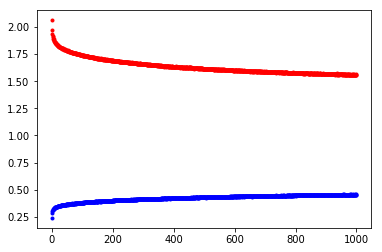

In [15]:
# y_loss에 학습셋으로 실험 결과의 오차 값을 저장
y_loss = history.history['loss']

# y_acc에 학습셋으로 측정한 정확도의 값을 저장
y_acc = history.history['acc']

# x값을 지정하고 정확도를 파랑색으로, 오차를 빨강색으로 표시
x_len = np.arange(len(y_acc))
plt.plot(x_len, y_loss, "o", c="red", markersize=3)
plt.plot(x_len, y_acc, "o", c="blue", markersize=3)

plt.show()
# loss: 1.5541 - acc: 0.4574
# 그냥 baseline 그대로 돌리면 loss 1.4783 acc 0.5014

In [ ]:
#   이런식으로  Y_test 해야함

# from math import sqrt
# from sklearn.metrics import mean_squared_error

# modelPred = model.predict(x_test)
# RMSE = sqrt(mean_squared_error(y_test, modelPred))
# RMSE